# Single-image food volume estimation
Using a  monocular depth estimation network and a segmentation network, we will estimate the volume of the food displayed in the input image.

In [1]:
!pwd

/home/abernardi/code/AntBernardi/food_volume_estimation/food_volume_estimation


In [2]:
%cd ..

/home/abernardi/code/AntBernardi/food_volume_estimation


In [3]:
!pip install .

Processing /home/abernardi/code/AntBernardi/food_volume_estimation
  Preparing metadata (setup.py) ... done
  Created wheel for food-volume-estimation: filename=food_volume_estimation-0.3-py3-none-any.whl size=109238 sha256=7865db7540da18c261063a6ddab40c287039149db1c7f504bce2e29eefe2d1a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-59i5ks6m/wheels/ed/f4/85/7a82de4bae5da5dd75e8bd0d7fbdc3f43f8566075b5f2961e2
Successfully built food-volume-estimation
  Attempting uninstall: food-volume-estimation
    Found existing installation: food-volume-estimation 0.3
    Not uninstalling food-volume-estimation at /home/abernardi/code/AntBernardi/food_volume_estimation, outside environment /home/abernardi/.pyenv/versions/3.6.15/envs/vol_estimation
    Can't uninstall 'food-volume-estimation'. No files were found to uninstall.


In [3]:
import sys
import json
from keras.models import Model, model_from_json
from food_volume_estimation.volume_estimator import VolumeEstimator
from food_volume_estimation.depth_estimation.custom_modules import *
from food_volume_estimation.food_segmentation.food_segmentator import FoodSegmentator
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud

# Paths to model archiecture/weights
depth_model_architecture = './models/fine_tune_food_videos/monovideo_fine_tune_food_videos.json'
depth_model_weights = '/home/abernardi/code/AntBernardi/food_volume_estimation/models/fine_tune_food_videos/monovideo_fine_tune_food_videos.h5'
segmentation_model_weights = './models/segmentation/mask_rcnn_food_segmentation.h5'

Using TensorFlow backend.
/home/abernardi/.pyenv/versions/3.6.15/envs/vol_estimation/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
# Create estimator object and intialize
estimator = VolumeEstimator(arg_init=False)
with open(depth_model_architecture, 'r') as read_file:
    custom_losses = Losses()
    objs = {'ProjectionLayer': ProjectionLayer,
            'ReflectionPadding2D': ReflectionPadding2D,
            'InverseDepthNormalization': InverseDepthNormalization,
            'AugmentationLayer': AugmentationLayer,
            'compute_source_loss': custom_losses.compute_source_loss}
    model_architecture_json = json.load(read_file)
    estimator.monovideo = model_from_json(model_architecture_json, custom_objects=objs)
estimator._VolumeEstimator__set_weights_trainable(estimator.monovideo, False)
estimator.monovideo.load_weights(depth_model_weights)
estimator.model_input_shape = estimator.monovideo.inputs[0].shape.as_list()[1:]
depth_net = estimator.monovideo.get_layer('depth_net')
estimator.depth_model = Model(inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
print('[*] Loaded depth estimation model.')

# Depth model configuration
MIN_DEPTH = 0.01
MAX_DEPTH = 10
estimator.min_disp = 1 / MAX_DEPTH
estimator.max_disp = 1 / MIN_DEPTH
estimator.gt_depth_scale = 0.35 # Ground truth expected median depth

# Create segmentator object
estimator.segmentator = FoodSegmentator(segmentation_model_weights)

# Set plate adjustment relaxation parameter
estimator.relax_param = 0.01

[*] VolumeEstimator not initialized.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use tf.cast instead.
[*] Loaded depth estimation model.
[*] Loading segmentation model weights ./models/segmentation/mask_rcnn_food_segmentation.h5


[*] Creating intrinsics matrix from given FOV: 70


/home/abernardi/code/AntBernardi/food_volume_estimation/food_volume_estimation/ellipse_detection/ellipse_center_estimator.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  cab_x = (mb[1] - tb * mb[0] - ma[1] + ta * ma[0]) / (ta - tb)
/home/abernardi/code/AntBernardi/food_volume_estimation/food_volume_estimation/ellipse_detection/ellipse_center_estimator.py:85: RuntimeWarning: divide by zero encountered in double_scalars
  cab_y = (ta * mb[1] - tb * ma[1] + ta * tb * (ma[0] - mb[0])) / (ta - tb)
/home/abernardi/code/AntBernardi/food_volume_estimation/food_volume_estimation/ellipse_detection/ellipse_center_estimator.py:85: RuntimeWarning: invalid value encountered in double_scalars
  cab_y = (ta * mb[1] - tb * ma[1] + ta * tb * (ma[0] - mb[0])) / (ta - tb)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 4 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3223721763629107, 0.20480821555099216, -0.0377634027550226, -0.978073371611343]
[*] Estimated volume: 0.037430765029895556 L


<IPython.core.display.Javascript object>


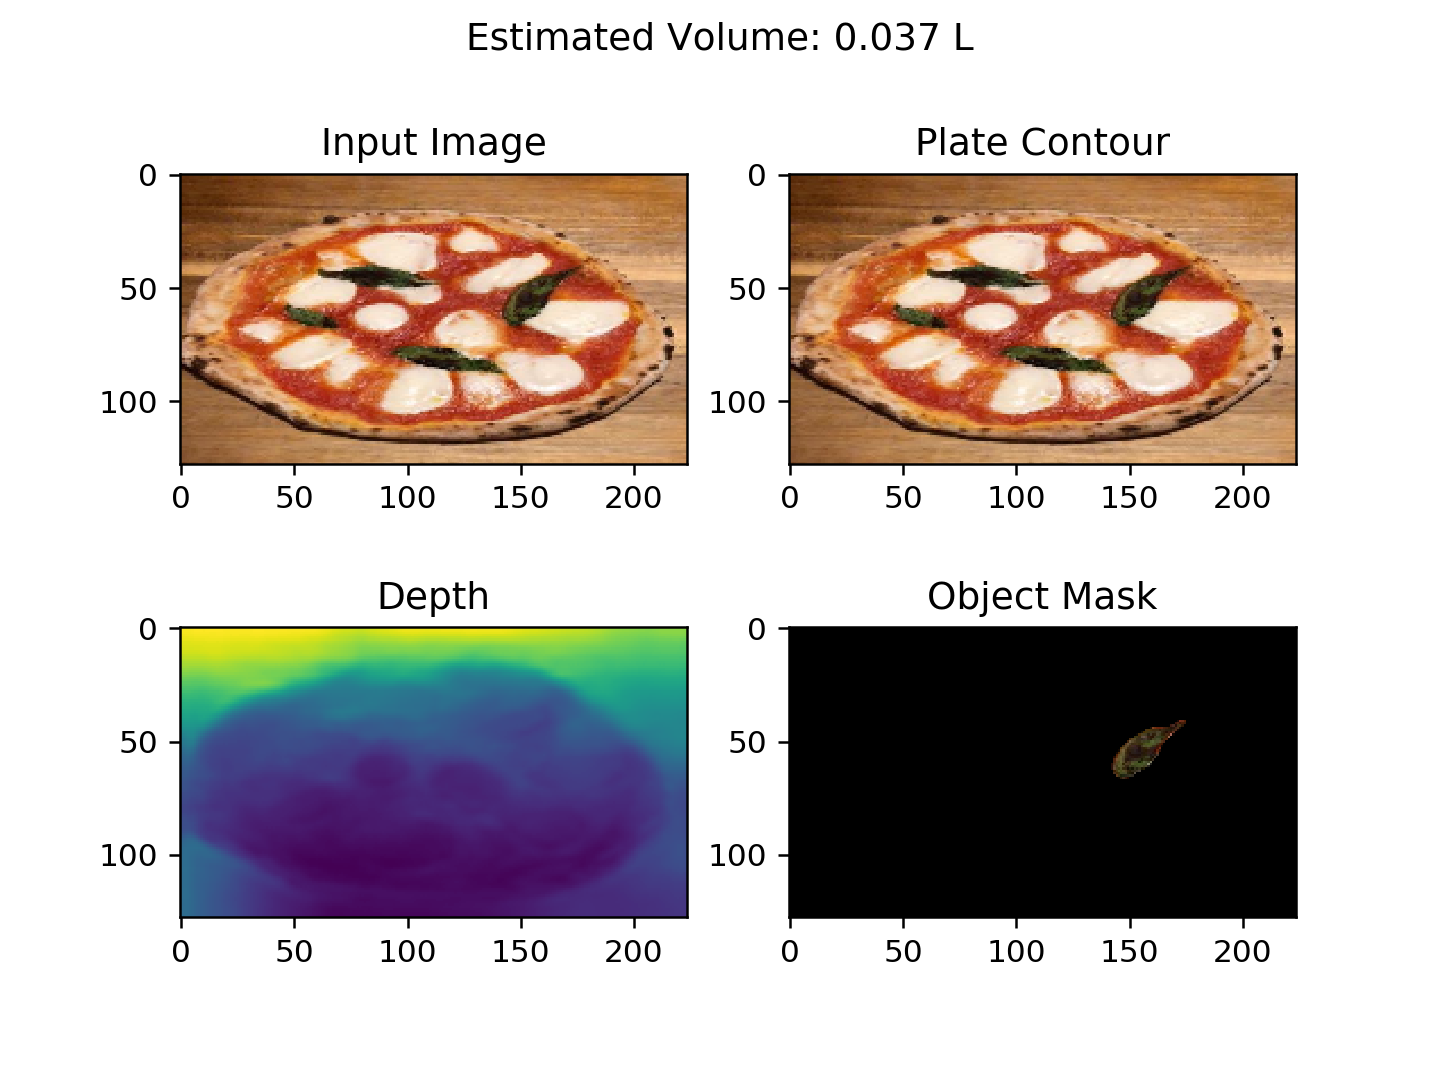

[*] Estimated plane parameters (w0,w1,w2,w3): [0.3189521148265349, -0.007223332930418034, -0.34714255099562824, -0.9377845556147874]
[*] Estimated volume: 2.8375066152840476 L


<IPython.core.display.Javascript object>


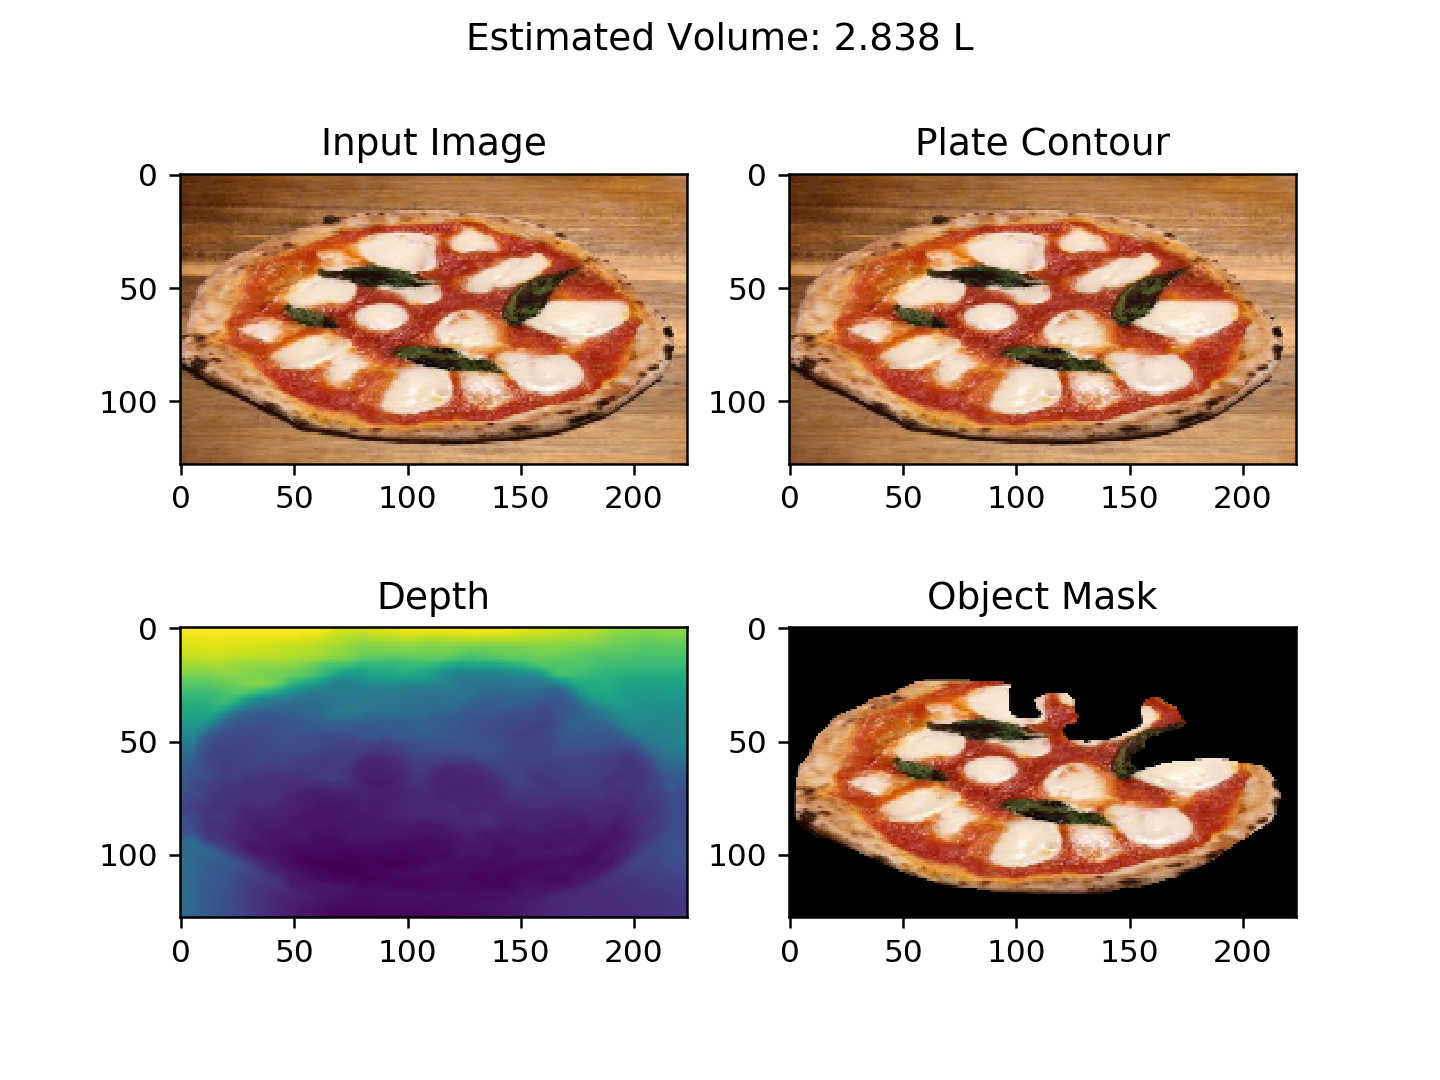

[*] Estimated plane parameters (w0,w1,w2,w3): [0.2822551810438747, 0.11206825721121608, -0.5245490908847462, -0.8439721304507792]
[*] Estimated volume: 0.015478894953171273 L


<IPython.core.display.Javascript object>


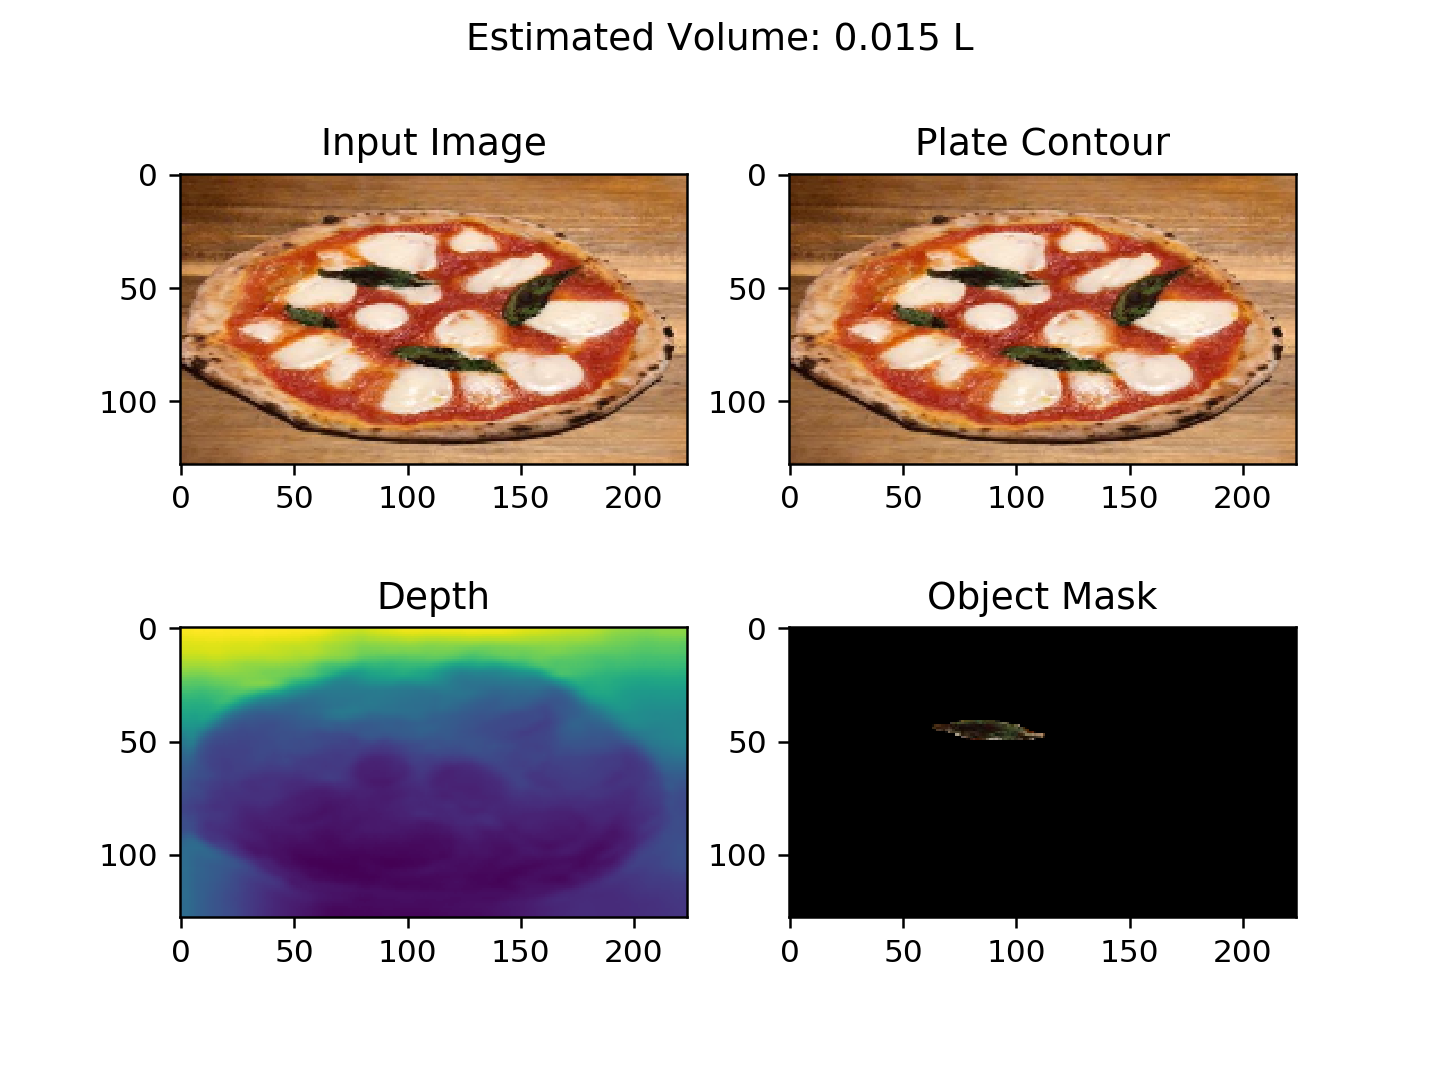

[*] Estimated plane parameters (w0,w1,w2,w3): [0.32347624373200523, 0.07447949337221751, -0.11775439365839512, -0.9902457815316162]
[*] Estimated volume: 0.009659695713108348 L


<IPython.core.display.Javascript object>


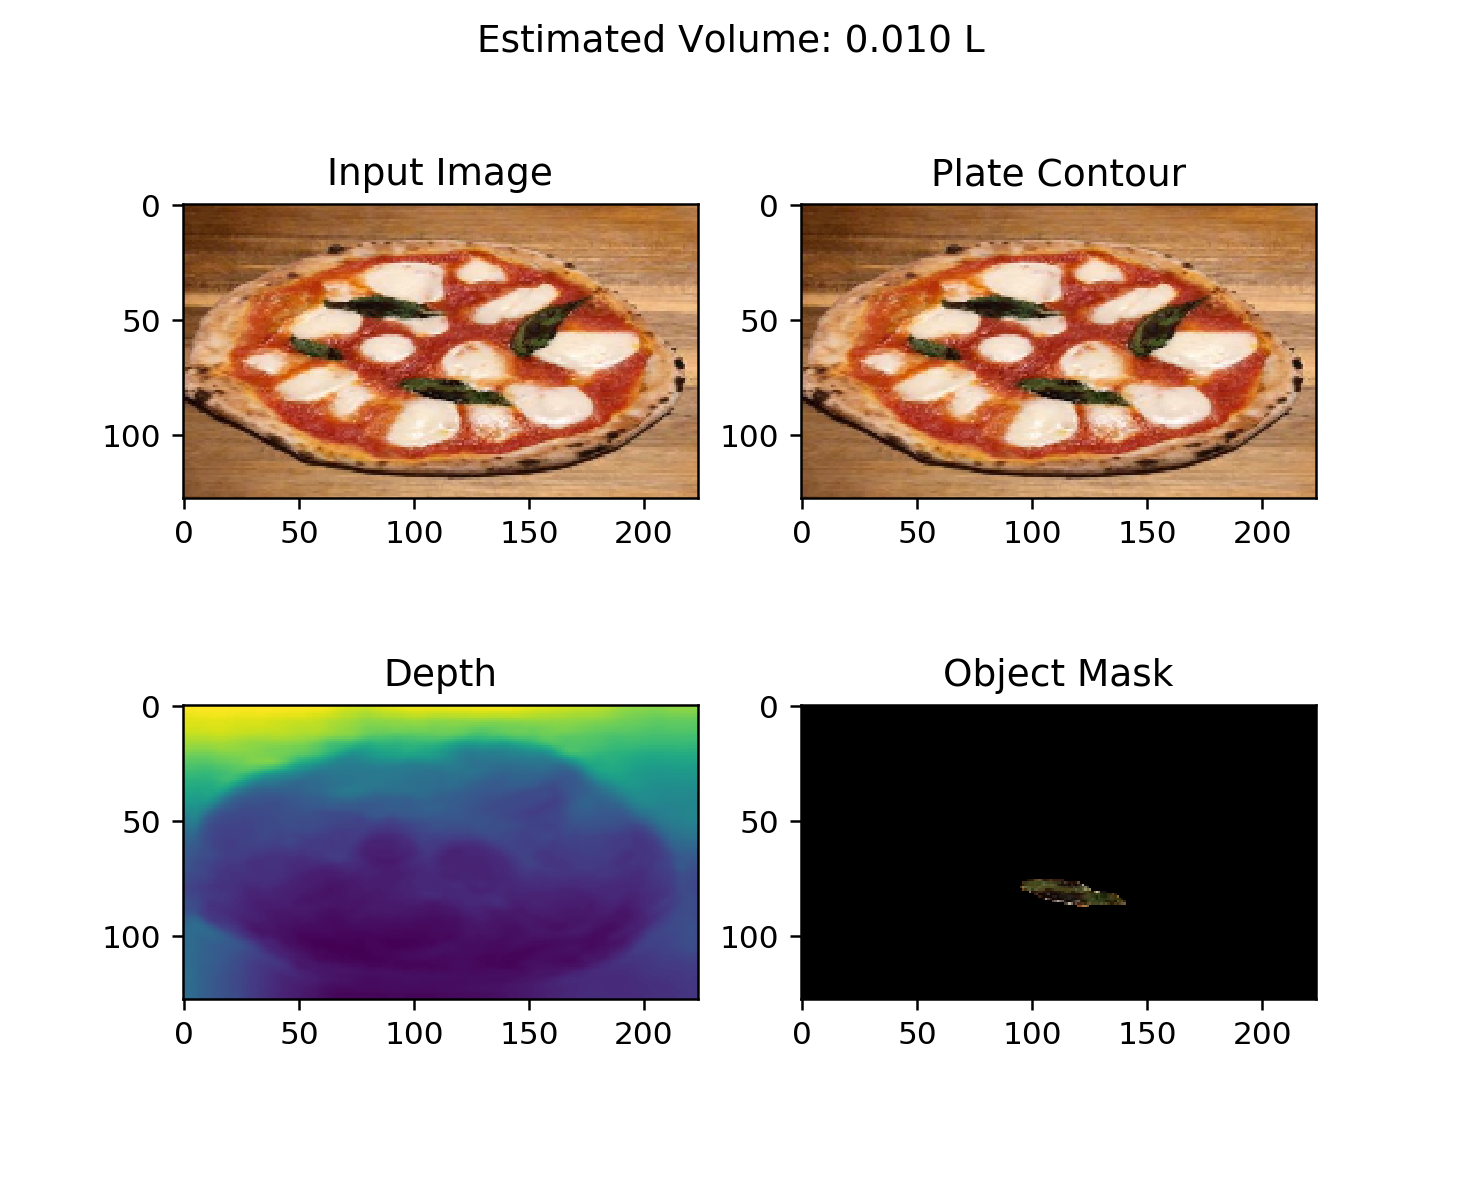

/home/abernardi/.pyenv/versions/3.6.15/envs/vol_estimation/lib/python3.6/site-packages/pythreejs/traits.py:191: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.09589229502396494, -0.03219202125262202, …

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.10211376851397036, 0.03548331811935466, 0…

<IPython.core.display.Javascript object>


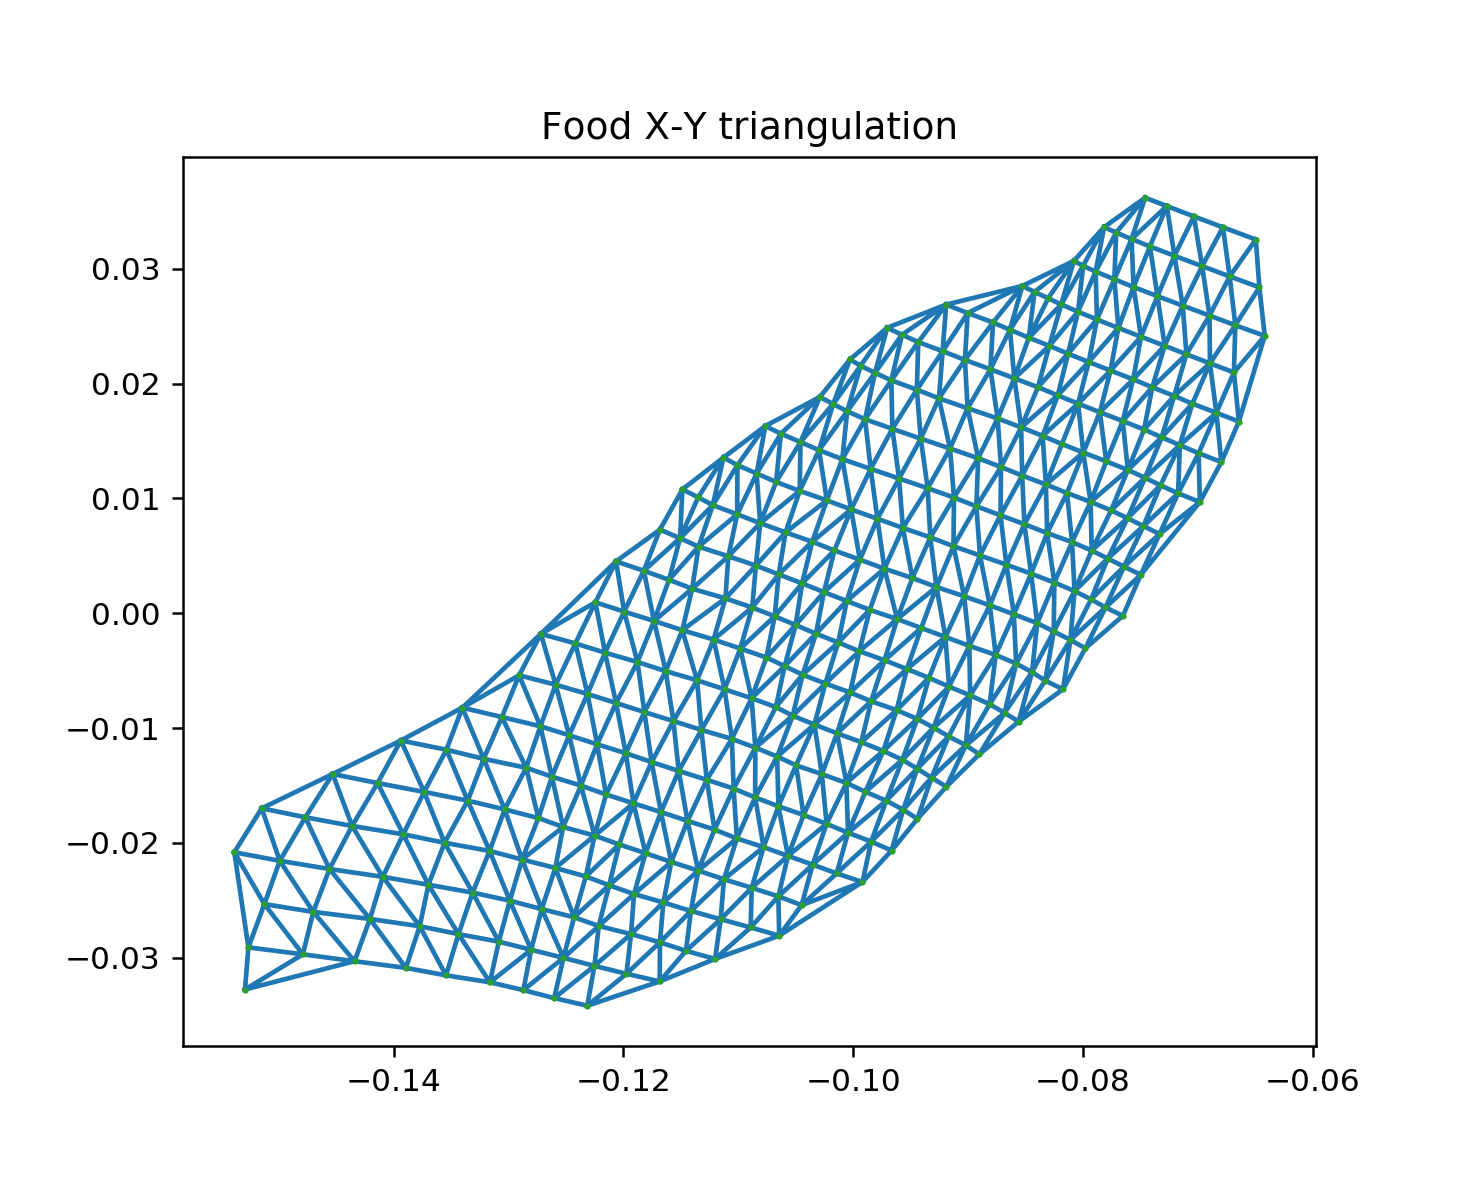

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.024048480873849778, 0.19767580353180908, 0…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.02494590091197774, 0.17469282476741868, 0…

<IPython.core.display.Javascript object>


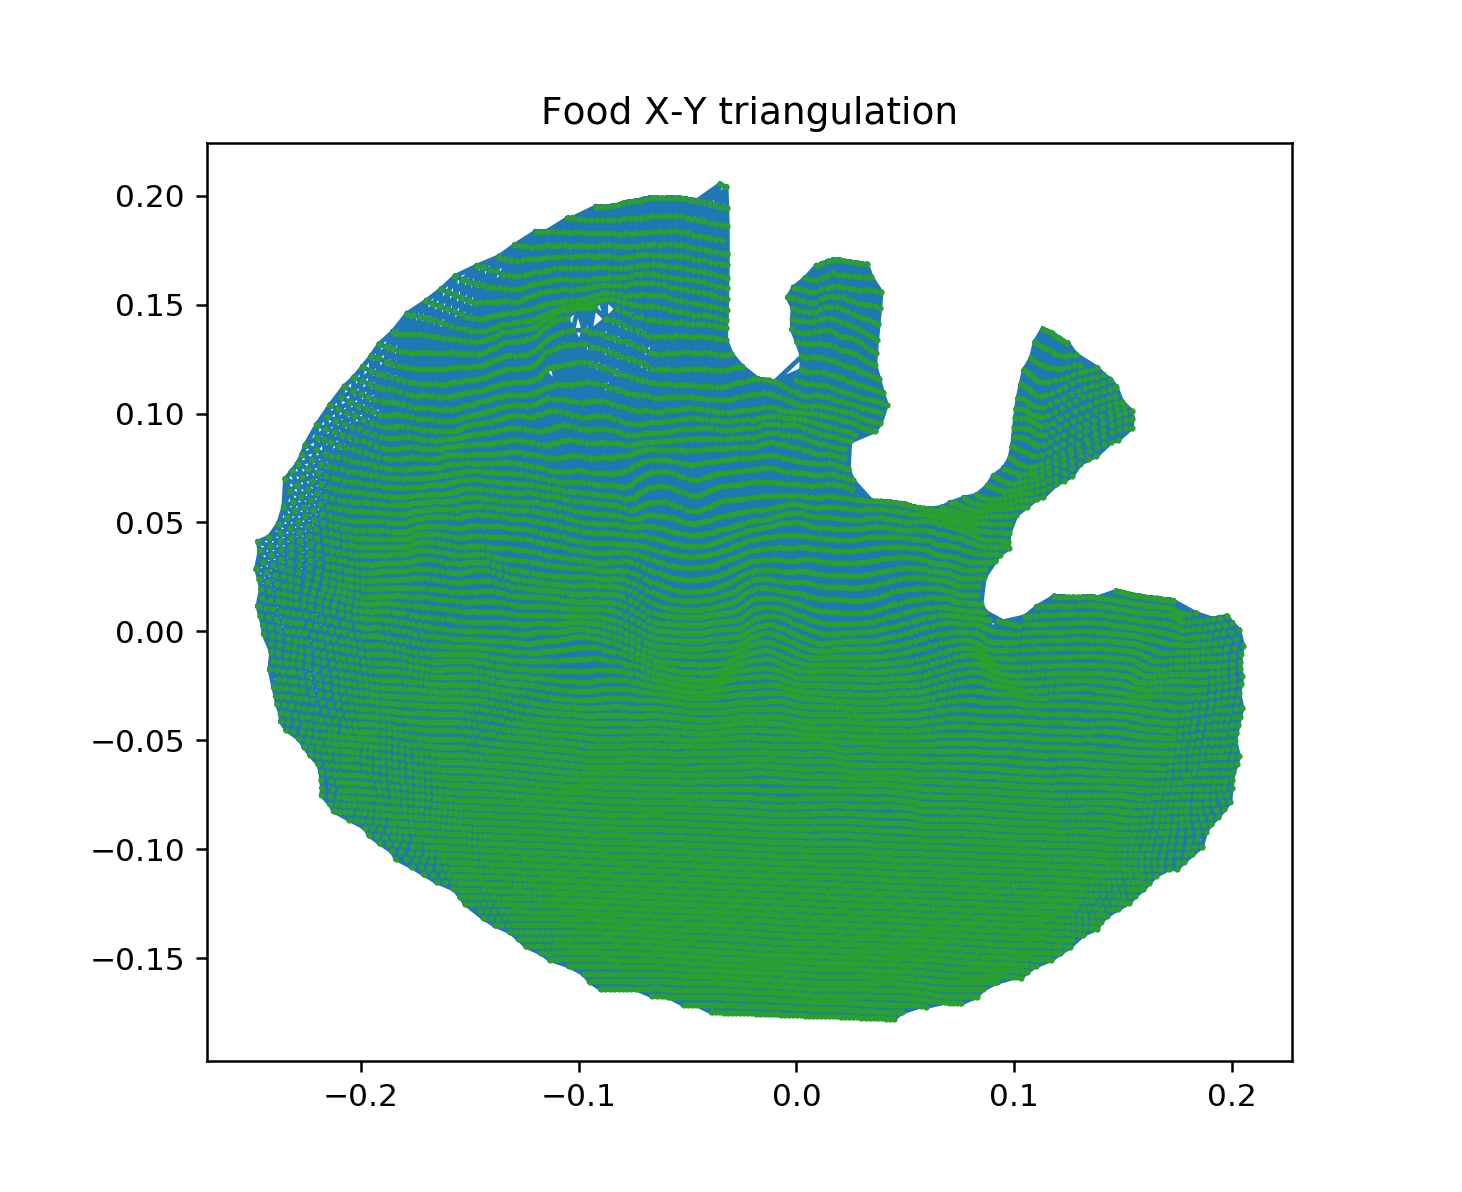

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.05758273040937091, -0.01864472634455759, 0…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.08590129380976975, 0.14154289126690353, 0…

<IPython.core.display.Javascript object>


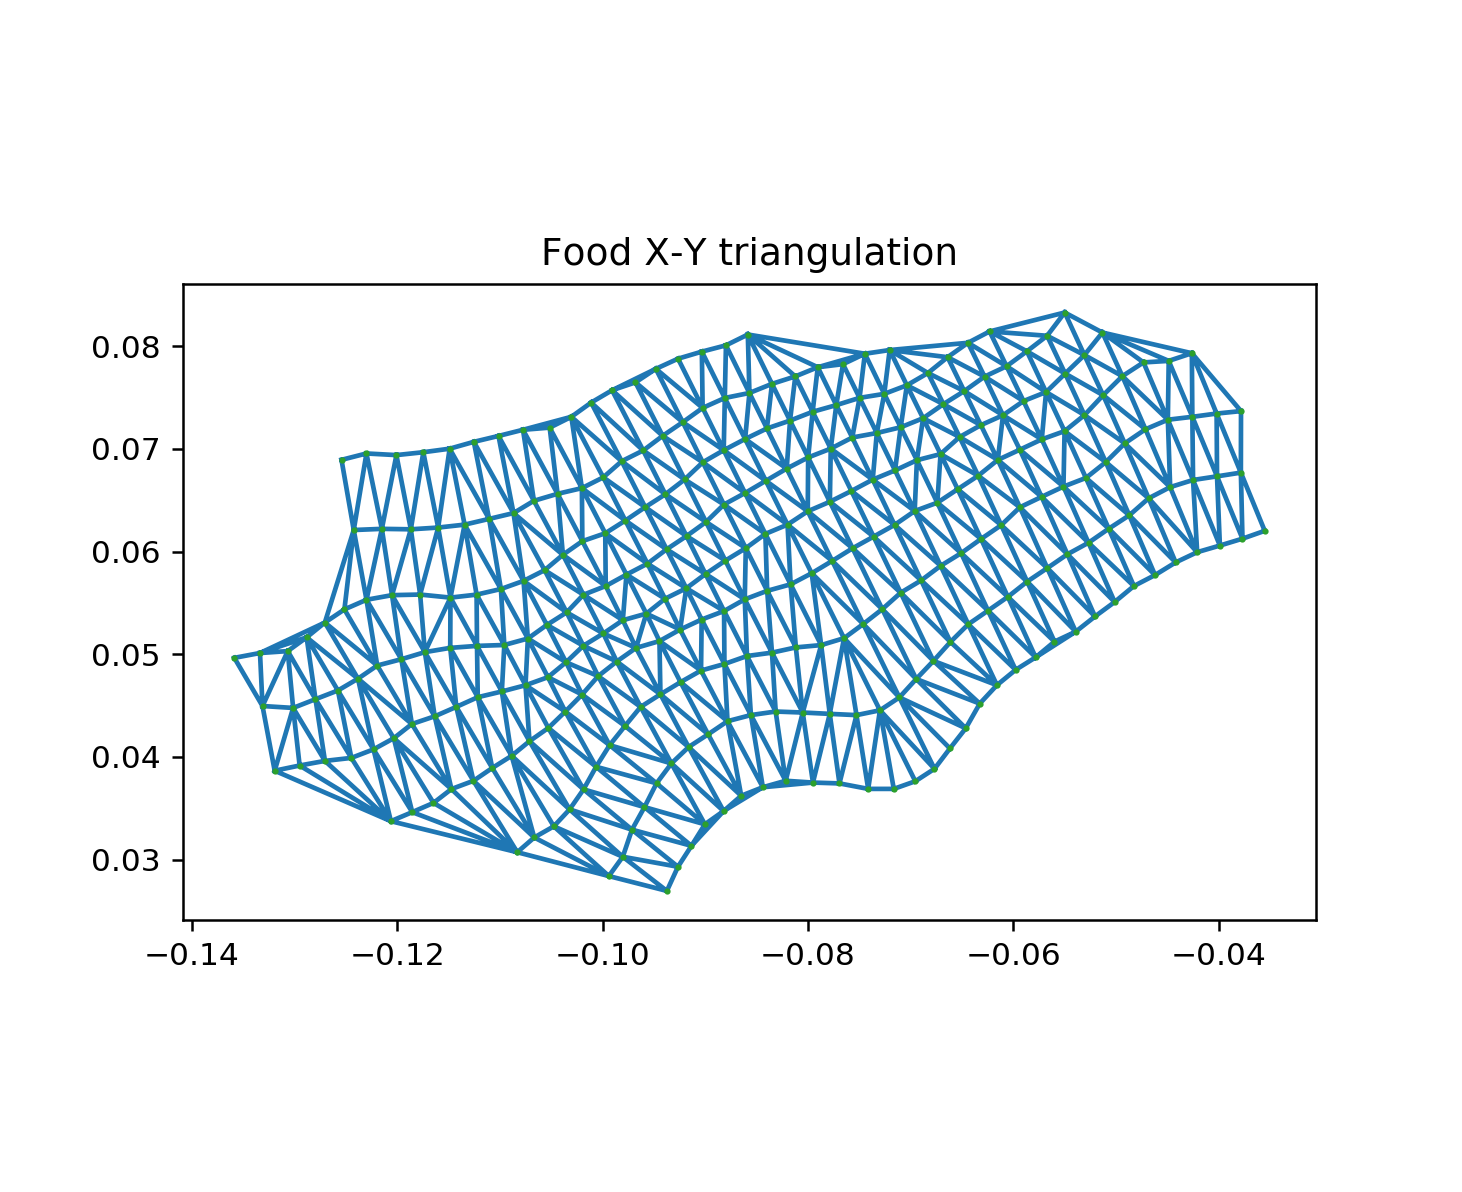

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.008747485975655634, 0.14089959989955175, …

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.05774503592844241, -0.0038522504653141325,…

<IPython.core.display.Javascript object>


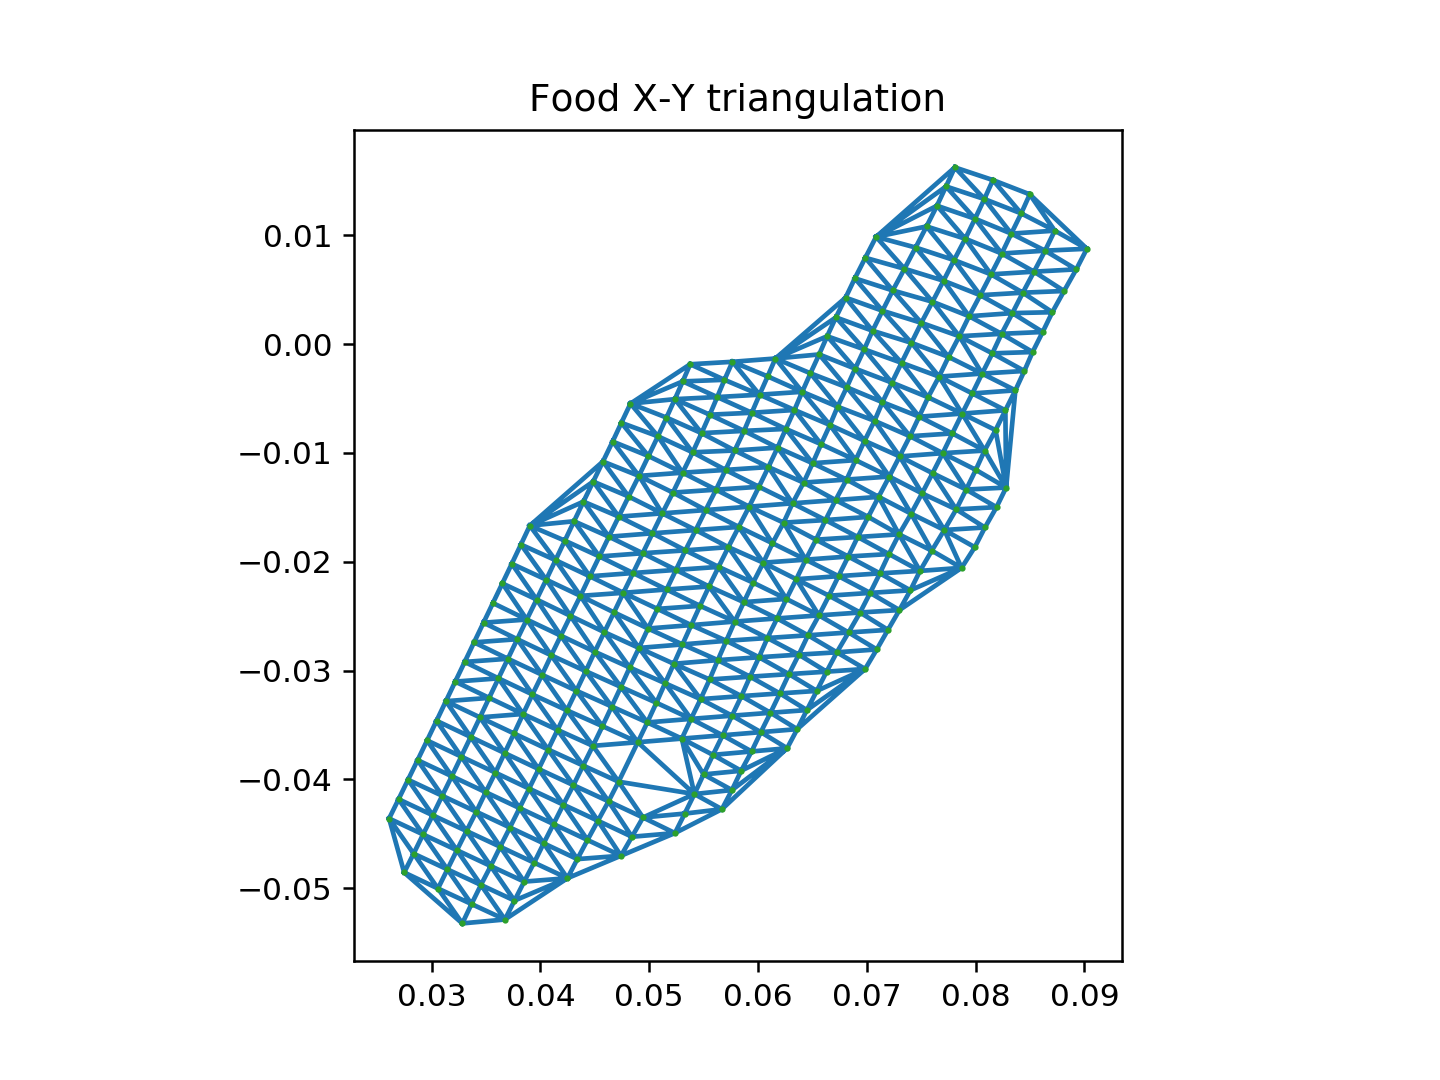

In [5]:
%matplotlib notebook

# Estimate volumes in input image
input_image = './datasets/006516.jpg'
plate_diameter = 0 # Set as 0 to ignore plate detection and scaling
outputs_list = estimator.estimate_volume(input_image, fov=70, plate_diameter_prior=plate_diameter, 
                                         plot_results=True)

# Plot results for all detected food objects
for outputs in outputs_list:
    (estimated_volume, object_points_df, non_object_points_df, plane_points_df, object_points_transformed_df, 
        plane_points_transformed_df, simplices) = outputs
    fig = plt.gcf()
    fig.set_size_inches(6.5, 5.3)
    
    # Flip x and z coordinates to match point cloud with plotting axes
    object_points_df.values[:,0] *= -1
    object_points_df.values[:,2] *= -1
    non_object_points_df.values[:,0] *= -1
    non_object_points_df.values[:,2] *= -1
    plane_points_df.values[:,0] *= -1
    plane_points_df.values[:,2] *= -1
    
    # Create point cloud objects and plot
    object_pc = PyntCloud(object_points_df)
    non_object_pc = PyntCloud(non_object_points_df)
    plane_pc = PyntCloud(plane_points_df)
    scene = object_pc.plot(initial_point_size=0.005, return_scene=True)
    non_object_pc.plot(initial_point_size=0.005, scene=scene)
    plane_pc.plot(initial_point_size=0.001, use_as_color='z', cmap='cool', scene=scene)
    
    # Create transformed point clouds and plot
    plane_transformed_pc = PyntCloud(plane_points_transformed_df)
    object_transformed_pc = PyntCloud(object_points_transformed_df)
    scene = object_transformed_pc.plot(initial_point_size=0.005, return_scene=True)
    plane_transformed_pc.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

    # Plot x-y plane triangulation of food object
    volume_points = object_points_transformed_df.values[object_points_transformed_df.values[:,2] > 0]
    plt.figure()
    plt.triplot(volume_points[:,0], volume_points[:,1], simplices)
    plt.plot(volume_points[:,0], volume_points[:,1], 'o', markersize=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Food X-Y triangulation')

    plt.show()